# RUN FIRST

In [1]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import time 

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])



In [3]:
# Checking the dataset training size.
dataset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

print('Size of training dataset :', len(dataset))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Size of training dataset : 50000


In [4]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 32, 32])


In [5]:
# Preview one of the images..
def show_image(img, label):
    plt.figure(figsize=(1,1))
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  frog (6)


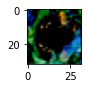

In [6]:
show_image(*dataset[200])

In [7]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [8]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(42500, 2500, 5000)

In [9]:
batch_size = 5 #change batch_size
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

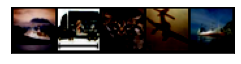

In [10]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(4,20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [11]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
# def accuracy(output, target, topk=(1,)):
#     """
#     Computes the accuracy over the k top predictions for the specified values of k
#     In top-3 accuracy you give yourself credit for having the right answer
#     if the right answer appears in your top five guesses.
#     """
#     with torch.no_grad():
#         batch_size = target.size(0)

#         # st()
#         _, pred = torch.topk(output,1)
#         pred = pred.t()
#         # st()
#         # correct = pred.eq(target.view(1, -1).expand_as(pred))
#         # correct = (pred == target.view(1, -1).expand_as(pred))
#         correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)

#         return correct.sum()/target.size(0)

# def accuracy(outputs, labels):
#    _, preds = torch.max(outputs, dim=1)
#    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# class ImageClassificationBase(nn.Module):
#     def training_step(self, batch):
#         images, labels = batch 
#         out = self(images)                  # Generate predictions
#         accuracy(out, labels)           # Calculate accuracy
#         loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy #chang
#         acc = accuracy(out, labels)           # Calculate accuracy
#         return {'train_loss': loss.detach(), 'train_acc': acc}

#     def training_epoch_end(self, outputs):
#         batch_losses = [x['train_loss'] for x in outputs]
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['train_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'train_loss': epoch_loss.item(), 'train_acc': epoch_acc.item()}
    
#     def validation_step(self, batch):
#         images, labels = batch 
#         out = self(images)                    # Generate predictions
#         loss = F.cross_entropy(out, labels)   # Calculate loss
#         acc = accuracy(out, labels)           # Calculate accuracy
#         return {'val_loss': loss.detach(), 'val_acc': acc}
        
#     def validation_epoch_end(self, outputs):
#         print(outputs)
#         batch_losses = [x['val_loss'] for x in outputs]
#         print(batch_losses)
#         epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
#         return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
#     def epoch_end(self, epoch, result):
#         print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, train_acc:{:.4f}, val_acc: {:.4f}".format(
#             epoch, result['train_loss'], result['val_loss'], result['train_acc'], result['val_acc']))

In [12]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [14]:
# input_size = 3*112*112
# output_size = 151
classes = dataset.classes
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
img, label = dataset[100]
print(img.shape)

torch.Size([3, 32, 32])


In [16]:
input_size = 3*32*32
output_size = 10

In [17]:
# Convolutional Network - mobilenet_v3
class ConvolutionalNetwork(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        super().__init__()
        self.num_classes=classes
        self.train_stats=[]
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)
        
    def forward(self, X):
          # -> n, 3, 32, 32
        X = self.pool(F.relu(self.conv1(X)))  # -> n, 6, 14, 14
        X = self.pool(F.relu(self.conv2(X)))  # -> n, 16, 5, 5
        X = X.view(-1, 16 * 5 * 5)            # -> n, 400
        X = F.relu(self.fc1(X))               # -> n, 120
        X = F.relu(self.fc2(X))               # -> n, 84
        X = self.fc3(X)                       # -> n, 10
        
        return X

In [59]:
# Functions for evaluation and training.

# @torch.no_grad()
# def evaluate(model, loader, eval_type=1):
#     model.eval()
#     outputs_t = list()
#     outputs_v = list()
#     if eval_type==1:
#       outputs_t = torch.Tensor([model.training_step(batch) for batch in loader])
#     elif eval_type==0:
#       outputs_v = torch.Tensor([model.validation_step(batch) for batch in loader])
    
#     print(outputs_t,outputs_v )
#     return model.validation_epoch_end(outputs_v),model.training_epoch_end_epoch_end(outputs_t)
  
# def acc_and_loss(model,loader,opt):
#         model.eval()
#         losses = []
#         acc_lst = []
#         mean_loss,acc = 0,0
#         lbl_sz =0
#         optimizer = opt
#         #NO gradient required as not training
#         with torch.no_grad():
#             for i, data in enumerate(loader, 0):
#                 # get the inputs
#                 inputs, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
#                 outputs = model(inputs)
#                 criterion = F.cross_entropy(outputs, labels) 
#                 #Accuracy
#                 lbl_sz+=labels.size(0)
#                 _, predicted = torch.max(outputs.data, 1)
#                 itm = (predicted == labels).sum().item()
#                 acc_lst.append(itm)
#                 #losses
#                 loss = criterion
#                 losses.append(loss.item())
#         mean_loss = np.mean(losses)
#         acc=(100 * np.sum(acc_lst) / lbl_sz)
#         return  acc,mean_loss

def acc_and_loss(model,loader,opt):

        model.eval()
        losses = []
        acc_lst = []
        mean_loss,acc = 0,0
        lbl_sz =0
        # criterion = cpt
        optimizer = opt
        #NO gradient required as not training
        with torch.no_grad():
            for i, data in enumerate(loader, 0):
                # get the inputs
                inputs, labels = data[0].to(get_default_device()), data[1].to(get_default_device())
                outputs = model(inputs)
                #Accuracy
                lbl_sz+=labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                itm = (predicted == labels).sum().item()
                acc_lst.append(itm)
                #losses
                loss = F.cross_entropy(outputs, labels)
                losses.append(loss.item())
        mean_loss = np.mean(losses)
        acc=(100 * np.sum(acc_lst) / lbl_sz)
        return  acc,mean_loss

# def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): 
#   train_stats = []

#   n_total_steps = len(train_loader)
#   for epoch in range(epochs):
#       for i, (images, labels) in enumerate(train_loader):
#           # origin shape: [4, 3, 32, 32] = 4, 3, 1024
#           # input_layer: 3 input channels, 6 output channels, 5 kernel size
#           images = images.to(device)
#           labels = labels.to(device)

#           # Flossorward pass
#           outputs = model(images)
#           loss = F.cross_entropy(outputs, labels)

#           # Backward and optimize
#           opt_func.zero_grad()
#           loss.backward()
#           opt_func.step()

#           if (i+1) % 2000 == 0:
#               print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
#       train_acc,train_loss = acc_and_loss(model,train_loader,opt_func,loss)
#       val_acc,val_loss = acc_and_loss(model,val_loader,opt_func,loss)

#       train_stat = {"epoch" : epoch+1,"train_loss" :train_loss,"train_acc" :train_acc,"val_acc": val_acc,"val_loss":val_loss}
#       print(train_stat)
#       train_stats.append(train_stat)
#       model.train_stats = train_stats
#   print('Finished Training')

def show_graph(epochs,model):
   train_accuracies = [x['train_acc'] for x in model.train_stats]
   val_accuracies = [x['val_acc'] for x in model.train_stats]  
   train_losses = [x['train_loss'] for x in model.train_stats]
   val_losses = [x['val_loss'] for x in model.train_stats] 
   print(train_accuracies)
   
   plt.figure(figsize=(5, 4))
   plt.title("Plotting Training/Validation Loss vs Epochs")
   plt.plot(np.arange(epochs), val_losses, label = "Validation Loss")
   plt.plot(np.arange(epochs), train_losses, label = "Training Loss")
   plt.legend()
   plt.show()
   
   plt.figure(figsize=(5, 4))
   plt.title("Plotting Training/Validation Accuracy  vs Epochs")
   plt.plot(np.arange(epochs), val_accuracies, label = "Validation Accuracy")
   plt.plot(np.arange(epochs), train_accuracies, label = "Training Accuracy")
   plt.legend()
   plt.show()

# def fit_A(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): #this works
#   n_total_steps = len(train_loader)
#   for epoch in range(num_epochs):
#       for i, (images, labels) in enumerate(train_loader):
#           # origin shape: [4, 3, 32, 32] = 4, 3, 1024
#           # input_layer: 3 input channels, 6 output channels, 5 kernel size
#           images = images.to(device)
#           labels = labels.to(device)

#           # Forward pass
#           outputs = model(images)
#           loss = F.cross_entropy(outputs, labels)

#           # Backward and optimize
#           opt_func.zero_grad()
#           loss.backward()
#           opt_func.step()

#           if (i+1) % 2000 == 0:
#               print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
#       result_t = acc_and_loss(model,train_loader,opt_func)
#       result_v = acc_and_loss(model,val_loader,opt_func)
#       print(f"Validation : {result_v}")
#       print(f"training : {result_t}")
#   print('Finished Training')



def fit_A(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD): #this works
  n_total_steps = len(train_loader)
  train_stats = []
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):
          # origin shape: [4, 3, 32, 32] = 4, 3, 1024
          # input_layer: 3 input channels, 6 output channels, 5 kernel size
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = F.cross_entropy(outputs, labels)

          # Backward and optimize
          opt_func.zero_grad()
          loss.backward()
          opt_func.step()

          if (i+1) % 2000 == 0:
              print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
      train_acc,train_loss = acc_and_loss(model,train_loader,opt_func)
      val_acc,val_loss = acc_and_loss(model,val_loader,opt_func)

      train_stat = {"epoch" : epoch+1,"train_loss" :train_loss,"train_acc" :train_acc,"val_acc": val_acc,"val_loss":val_loss}
      print(train_stat)
      train_stats.append(train_stat)
      model.train_stats = train_stats
  print('Finished Training')

def acc_by_class(batch_size,model, val_loader):
  with torch.no_grad():
      n_correct = 0
      n_samples = 0
      n_class_correct = [0 for i in range(10)]
      n_class_samples = [0 for i in range(10)]
      for images, labels in val_loader:
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          # max returns (value ,index)
          _, predicted = torch.max(outputs, 1)
          n_samples += labels.size(0)
          n_correct += (predicted == labels).sum().item()
          
          for i in range(batch_size):
              label = labels[i]
              pred = predicted[i]
              if (label == pred):
                  n_class_correct[label] += 1
              n_class_samples[label] += 1

      acc = 100.0 * n_correct / n_samples
      print(f'Accuracy of the network: {acc} %')

      for i in range(10):
          acc = 100.0 * n_class_correct[i] / n_class_samples[i]
          print(f'Accuracy of {classes[i]}: {acc} %')

# Experiment 0

In [60]:
# Model print
num_classes = len(classes)
model = ConvolutionalNetwork(num_classes)
model.to(device)
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [49]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([5, 3, 32, 32])
out.shape: torch.Size([5, 10])
out[0]: tensor([-0.1048,  0.0549, -0.0027, -0.0757,  0.0174,  0.0773,  0.0539, -0.1202,
         0.0113,  0.0694], device='cuda:0', grad_fn=<SelectBackward0>)


In [50]:
# train_dl = DeviceDataLoader(train_loader, device)
# val_dl = DeviceDataLoader(val_loader, device)
# to_device(model, device)

In [61]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 3 #5
lr = 0.001 
optimizer = torch.optim.SGD(model.parameters(), lr=lr), momentum=0.9)


5000


In [62]:
# fit(num_epochs, lr, model, train_loader, val_loader, optimizer)

KeyboardInterrupt: ignored

In [63]:
start = time.time()
fit_A(num_epochs, lr, model, train_loader, val_loader, optimizer)
print(time.time()-start)

Epoch [1/3], Step [2000/8500], Loss: 2.2832
Epoch [1/3], Step [4000/8500], Loss: 2.3126
Epoch [1/3], Step [6000/8500], Loss: 2.2852
Epoch [1/3], Step [8000/8500], Loss: 2.2966
{'epoch': 1, 'train_loss': 2.2730286808013918, 'train_acc': 19.52235294117647, 'val_acc': 19.88, 'val_loss': 2.273316415309906}
Epoch [2/3], Step [2000/8500], Loss: 2.1848
Epoch [2/3], Step [4000/8500], Loss: 1.9124
Epoch [2/3], Step [6000/8500], Loss: 1.9434
Epoch [2/3], Step [8000/8500], Loss: 2.5476
{'epoch': 2, 'train_loss': 1.9659912455222186, 'train_acc': 29.19764705882353, 'val_acc': 28.64, 'val_loss': 1.9807970929145813}
Epoch [3/3], Step [2000/8500], Loss: 1.9600
Epoch [3/3], Step [4000/8500], Loss: 1.9138
Epoch [3/3], Step [6000/8500], Loss: 1.8891
Epoch [3/3], Step [8000/8500], Loss: 3.0105
{'epoch': 3, 'train_loss': 1.7882900210829342, 'train_acc': 35.548235294117646, 'val_acc': 34.04, 'val_loss': 1.8119521349668504}
Finished Training


[19.52235294117647, 29.19764705882353, 35.548235294117646]


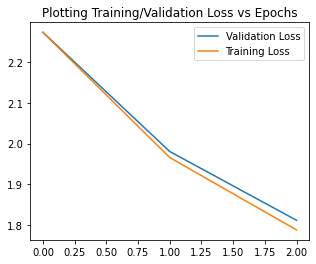

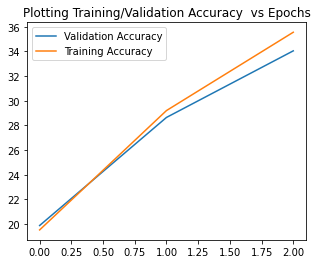

In [64]:
show_graph(num_epochs,model)

In [65]:
acc_by_class(batch_size,model, val_loader)

Accuracy of the network: 34.04 %
Accuracy of airplane: 39.11290322580645 %
Accuracy of automobile: 24.313725490196077 %
Accuracy of bird: 14.225941422594142 %
Accuracy of cat: 16.666666666666668 %
Accuracy of deer: 38.9344262295082 %
Accuracy of dog: 31.417624521072796 %
Accuracy of frog: 43.47826086956522 %
Accuracy of horse: 40.92827004219409 %
Accuracy of ship: 47.96747967479675 %
Accuracy of truck: 43.61702127659574 %


In [1]:
# #incorrectly classifed

# incorrect_examples = []
# incorrect_labels = []
# incorrect_pred = []
# model.eval()
# for data,target in test_loader:
#   data , target = data.to(device), target.to(device)
#   output = model(data) # shape = torch.Size([batch_size, 10])
#   pred = output.argmax(dim=1, keepdim=True) #pred will be a 2d tensor of shape [batch_size,1]
#   idxs_mask = ((pred == target.view_as(pred))==False).view(-1)
  
#   if idxs_mask.numel(): #if index masks is non-empty append the correspoding data value in incorrect examples
#     incorrect_examples.append(data[idxs_mask].squeeze().cpu().numpy())
#     incorrect_labels.append(target[idxs_mask].cpu().numpy()) #the corresponding target to the misclassified image
#     incorrect_pred.append(pred[idxs_mask].squeeze().cpu().numpy()) #the corresponiding predicted class of the misclassified image


NameError: ignored

In [20]:

# first_index = 1
# second_index = 1

# img = incorrect_examples[first_index][second_index]
# print('label:', incorrect_labels[first_index][second_index], dataset.classes[incorrect_labels[first_index][second_index]])
# print('predicted:', incorrect_pred[first_index][second_index], dataset.classes[incorrect_pred[first_index][second_index]])
# img = img.swapaxes(0, 1)
# img = img.swapaxes(1, 2)
# plt.figure(figsize=(1,1))
# plt.imshow(img)


IndexError: ignored

##FLOPs

In [ ]:
  #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  #Download the code.
  !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  !mv download FLOPs_counter.py
  #!rm -rf download

In [ ]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 32, 32) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = len(classes)
model = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model, input, detail=False)